In [1]:
# Setting up the notebook
import sys
sys.path.append("../scripts")

In [2]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt

from config import REQUESTS_DIR, RESPONSES_DIR, SCRIPTS_DIR
import functions as func

# 1. PRE-PROCESSING

## 1.1 Creation of Data Table

In [3]:
requests_df = func.create_df_of_requests(REQUESTS_DIR)
responses_df = func.create_df_of_responses(RESPONSES_DIR)
joined_df = func.join_requests_and_responses(requests_df, responses_df)

In [4]:
# A result
joined_df.head()

,row_id,route_id,date,time,request_id,request_type,task_id,lat,lon,location_id,fixed,position_fixed,task_sequence_number
0,0521_300-20220617-055733-2-0-395,300,2022-06-17,05:57:33,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,5658256722186827,False,NaN,2
1,0521_300-20220617-055733-2-0-394,300,2022-06-17,05:57:33,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,5658256722186827,False,NaN,1
2,0521_300-20220617-085002-2-0-385,300,2022-06-17,08:50:02,5737d4ef-23e9-4832-8bb5-24340a176e31,CreateSequence,385,0.565826,0.221868,5658256722186827,False,NaN,2
3,0521_300-20220617-085002-2-0-384,300,2022-06-17,08:50:02,5737d4ef-23e9-4832-8bb5-24340a176e31,CreateSequence,384,0.565826,0.221868,5658256722186827,False,NaN,1
4,0521_300-20220617-092416-2-0-390,300,2022-06-17,09:24:16,34f409b3-9f92-4720-9926-48ca1cbf6f90,CreateSequence,390,0.565826,0.221868,5658256722186827,False,NaN,2


## 1.2 Solving Pre-Requisites

### Defining unique location IDs by clustering: DBSCAN

**PURPOSE**

The coordinates provided are floats (created by transformation of the original 'real' coordinates). Analyses requiring comparison of unique locations necessitate assignment of a unique location ID. We posited that small differences in floating point numbers might in reality refer to the same location. A clustering function was developed to assign locations that are tightly spread within a defined cut-off (e.g., 5 m) to the same location ID.

In [5]:
# Maxime to either add functions to the "functions.py" file or create a new file for the location IDs + verification; then import for execution.


### Finding the time threshold ("cut-off") for further analyses

**PURPOSE**

Requests follow a pulsed pattern, with a first wave of intense activity representing organization of the daily deliveries, which is our subject of interest. A second large activity peak is irrelevant for the analysis. We want to define where to set the "cursor". 

In [6]:
# Karen to import necessary functions for her time pattern analysis (functions to be added to the "functions.py" file)


In [7]:
# Choice of time threshold
thresh = pd.to_datetime("12:00:00").time()

# 2. DATA EXPLORATION

In [8]:
# Karen to develop with some interesting plots she generated. 
# One analysis we agreed upfront was to evaluate how many requests are made before a route is defined, on average, 
# but also as a function of the routeID (driver), over time...
# Let's select the most interesting / informative plots.


# 3. DATA ANALYSIS

## 3.1 GRANULAR ANALYSIS

**RESEARCH QUESTION**

Two optimization models are used in combination: model 1 assigns tasks to routeIDs (regions), model 2 predicts the optimal sequence of locations (the optimal "trip"). Our objective is to evaluate the most common change made by the user: a change in the number of taskIDs (which would suggest non-optimality of model 1) or a change in the sequence of taskIDs (locations) (which would suggest non-optimality of model 2).

In [9]:
# I am adding this section as it is part of our thinking process so deserves to be mentioned; but not sure whether we actually developed code for this?
# The Levenshtein distance was suggested here - did we develop something?


## 3.2 CHANGE IMPACT ANALYSIS

**RESEARCH QUESTION**

The project's base hypothesis states that the model predictions are deemed non-optimal given the extent of human intervention observed to yield final routes. The trueness of this hypothesis deserves further assessment: does human intervention produce a more optimal result?

For this, the total distance to be driven following the model's recommendations can be compared to the distance to be driven after all human interventions. As taskIDs are not constant within regions and days (i.e., tasks are assumed to migrate between regions), an aggregated computation across all regions connected to warehouse 0521 will be performed. This is based on the assumption that taskIDs may change within routeIDs (per day) due to assignment to other routeIDs of the same warehouse. 

*STEP 1: Evaluation of Assumption*

In [10]:
# I will develop this part.

filtered_requests_df = requests_df[requests_df["time"] < thresh].loc[:, ["route_id", "date", "time", "request_type", "location_id"]]
counted_tasks_df = func.count_tasks_per_sequence(filtered_requests_df)
select_compare_start_end_df = func.select_compare_start_and_end(counted_tasks_df)

Text(0.5, 1.0, 'Change in number of tasks over warehouse 0521 between start and end of shift')

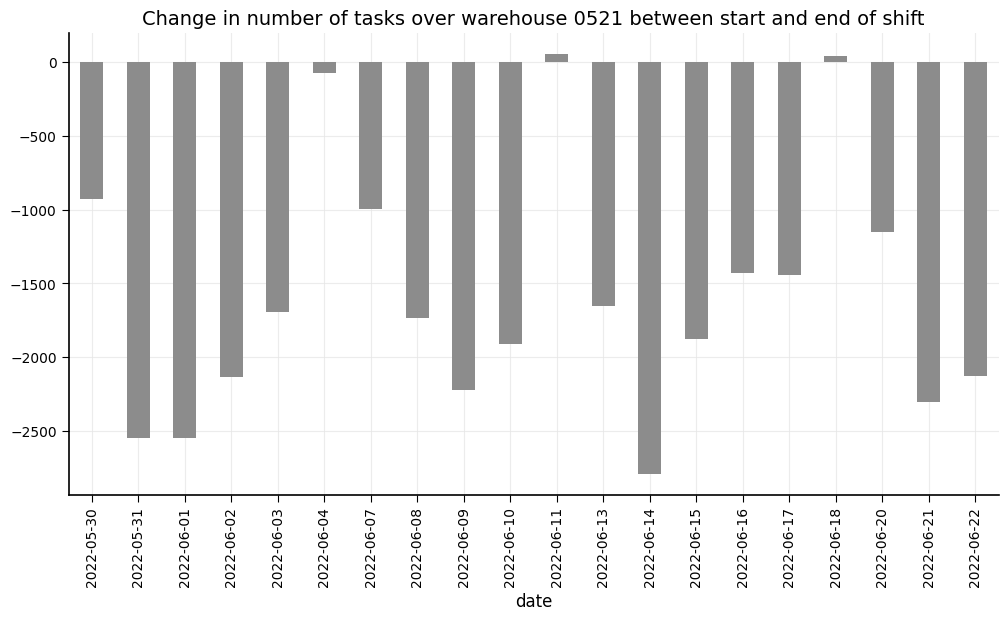

In [11]:
# Verifying the assumption
plt.style.use(SCRIPTS_DIR / "plot_style.mplstyle") # May have to be put elsewhere

ax = (select_compare_start_end_df.groupby("date")["abs_diff_end_start"]
    .sum()
    .reset_index(name="diff_per_day")
    .plot(x="date", y="diff_per_day", kind="bar", legend=False))

ax.set_title("Change in number of tasks over warehouse 0521 between start and end of shift")

**_CONCLUSION_**

The assumption is clearly false. Further comparison of the total distance between model output and human output is not useful.